In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
import numpy as np

def get_labels_number(res_dict: dict):
    labels_model_custom = defaultdict(int)
    for label in res_dict["label"]:
        labels_model_custom[label] += 1
    labels_model_custom = dict(sorted(labels_model_custom.items(), key=lambda x:x[0]))
    labels_model_custom = {label: round(val/len(res_dict["label"]) * 100,2) for label, val in labels_model_custom.items()}
    # print(labels_model_custom)
    return labels_model_custom

import json

def load_data(file_name):
    data = {
            "id": [],
            "label": [],
            "prob": [],
            "all_prob": []
    }
    with open(file_name, "r") as file:
        for line in file:
            aux_dict = json.loads(line)
            
            data["id"] += [aux_dict["id"]]
            data["label"] += [aux_dict["result"]["label"]]
            data["prob"] += [aux_dict["result"]["prob"]]
            data["all_prob"] += [aux_dict["result"]["all_prob"]]

    return data

In [15]:
import json
import pandas as pd

# data_path = "data/" + "/multinli_1.0" + "/multinli_1.0_dev_mismatched.jsonl"
# data_path = "data/" + "/multinli_1.0" + "/multinli_1.0_dev_matched.jsonl"
data_path = "data/" + "/snli_1.0" + "/snli_1.0_test.jsonl"

data = []
limit = 500_000
with open(data_path, "r") as file:
    for _ in range(limit):
        json_obj = file.readline()
        if json_obj != "":
            data += [json.loads(json_obj)]
        else:
            break

data_df = {
    "label": [],
    "sent1": [],
    "sent2": []
}

for datum in data:
    data_df["label"] += [datum["gold_label"]]
    data_df["sent1"] += [datum["sentence1"]] # premise
    data_df["sent2"] += [datum["sentence2"]] # hypothesis

data_df = pd.DataFrame(data_df)
print(data_df.shape)
data_df.head()

gt_labels=data_df["label"].to_numpy()
gt_labels_num = data_df["label"].value_counts().to_dict()

gt_labels_num = dict(sorted(gt_labels_num.items(), key=lambda x:x[0]))
gt_labels_num = {label: round(val/len(gt_labels) * 100, 2) for label, val in gt_labels_num.items()}
gt_labels_num

(10000, 3)


{'-': 1.76, 'contradiction': 32.37, 'entailment': 33.68, 'neutral': 32.19}

In [34]:
def per_label_accuracy(original_labels, predicted_labels, label):
    label_mask = original_labels == label
    original_labels = original_labels[label_mask]
    predicted_labels = predicted_labels[label_mask]

    return round(sum(original_labels == predicted_labels)/len(original_labels),2)

In [35]:
import os

# dataset_name = "multinli_1.0_dev_mismatched"
# dataset_name = "multinli_1.0_dev_matched"
dataset_name = "snli_1.0_test"
path = "results/minilm/"
for file in os.listdir(path):
    if dataset_name not in file:
        continue
    results = load_data(path + file)
    file = "-".join(file.split("-")[1:])
    results_labels_num = get_labels_number(results)
    labels_pred = np.asarray(results["label"])
    accuracy = sum(labels_pred == gt_labels)/len(gt_labels)

    contradiction_acc = str(per_label_accuracy(gt_labels, labels_pred, 'contradiction'))
    entailment_acc = str(per_label_accuracy(gt_labels, labels_pred, 'entailment'))
    neutral_acc = str(per_label_accuracy(gt_labels, labels_pred, 'neutral'))

    print(f"{file} \tAccuracy={accuracy}\tDist={results_labels_num} ({sum(results_labels_num.values())})\t{'/'.join([contradiction_acc, entailment_acc, neutral_acc])}")
    print("-----------------------------------------")

unigram_tokenizer-minilm.jsonl 	Accuracy=0.8944	Dist={'contradiction': 32.67, 'entailment': 34.41, 'neutral': 32.92} (100.0)	0.93/0.92/0.88
-----------------------------------------
greedy_prefix_tokenization-minilm.jsonl 	Accuracy=0.4391	Dist={'contradiction': 47.12, 'entailment': 52.8, 'neutral': 0.08} (99.99999999999999)	0.6/0.72/0.0
-----------------------------------------
adverserial_shuffle_letters-minilm.jsonl 	Accuracy=0.7599	Dist={'contradiction': 36.45, 'entailment': 29.92, 'neutral': 33.63} (100.0)	0.84/0.73/0.76
-----------------------------------------
adverserial_shuffle_tokens_one_neighbour-minilm.jsonl 	Accuracy=0.8753	Dist={'contradiction': 32.38, 'entailment': 34.91, 'neutral': 32.71} (100.0)	0.91/0.91/0.86
-----------------------------------------
standard-minilm.jsonl 	Accuracy=0.8781	Dist={'contradiction': 31.22, 'entailment': 36.36, 'neutral': 32.42} (100.0)	0.9/0.93/0.85
-----------------------------------------
greedy_longest_tokenization-minilm.jsonl 	Accuracy

In [21]:
import json

def load_data(file_name):
    data = {
            "id": [],
            "label": [],
            "prob": [],
            "all_prob": []
    }
    with open(file_name, "r") as file:
        for line in file:
            aux_dict = json.loads(line)
            
            data["id"] += [aux_dict["id"]]
            data["label"] += [aux_dict["result"]["label"]]
            data["prob"] += [aux_dict["result"]["prob"]]
            data["all_prob"] += [aux_dict["result"]["all_prob"]]

    return data

results_adj = load_data("results/bart/multinli_1.0_dev_mismatched-adj-bart.jsonl")
results_noun = load_data("results/bart/multinli_1.0_dev_mismatched-noun-bart.jsonl")
results_standard = load_data("results/bart/multinli_1.0_dev_mismatched-standard-bart.jsonl")
results_char = load_data("results/bart/multinli_1.0_dev_mismatched-char-bart.jsonl")
results_verb = load_data("results/bart/multinli_1.0_dev_mismatched-verb-bart.jsonl")
results_unigram = load_data("results/bart/multinli_1.0_dev_mismatched-unigram_tokenizer-bart.jsonl")

In [22]:
results_adverserial_syn = load_data("results/bart/multinli_1.0_dev_mismatched-adverserial_pos_synonym_noun-bart.jsonl")
results_adverserial_letter = load_data("results/bart/multinli_1.0_dev_mismatched-adverserial_shuffle_letters-bart.jsonl")

In [ ]:
import json
import pandas as pd

# data_path = "data/" + "/snli_1.0" + "/snli_1.0_test.jsonl"
data_path = "data/" + "/multinli_1.0" + "/multinli_1.0_dev_mismatched.jsonl"

data = []
limit = 500_000
with open(data_path, "r") as file:
    for _ in range(limit):
        json_obj = file.readline()
        if json_obj != "":
            data += [json.loads(json_obj)]
        else:
            break

data_df = {
    "label": [],
    "sent1": [],
    "sent2": []
}

for datum in data:
    data_df["label"] += [datum["gold_label"]]
    data_df["sent1"] += [datum["sentence1"]] # premise
    data_df["sent2"] += [datum["sentence2"]] # hypothesis

data_df = pd.DataFrame(data_df)
print(data_df.shape)
data_df.head()

gt_labels=data_df["label"].to_numpy()
gt_labels_num = data_df["label"].value_counts().to_dict()

gt_labels_num = dict(sorted(gt_labels_num.items(), key=lambda x:x[0]))

gt_labels_num

(10000, 3)


{'-': 168, 'contradiction': 3240, 'entailment': 3463, 'neutral': 3129}

In [18]:
print(sum(results_adverserial_letter["label"] == gt_labels)/len(gt_labels))
print(sum(results_standard["label"] == gt_labels)/len(gt_labels))
print(sum(results_adverserial_syn["label"] == gt_labels)/len(gt_labels))
print(sum(results_unigram["label"] == gt_labels)/len(gt_labels))

0.7209
0.8282
0.8086
0.8518


In [28]:
from collections import defaultdict
import numpy as np

def get_labels_number(res_dict: dict):
    labels_model_custom = defaultdict(int)
    for label in res_dict["label"]:
        labels_model_custom[label] += 1
    labels_model_custom = dict(sorted(labels_model_custom.items(), key=lambda x:x[0]))
    print(labels_model_custom)
    return labels_model_custom

results_adj_num = get_labels_number(results_adj)
results_noun_num = get_labels_number(results_noun)
results_standard_num = get_labels_number(results_standard)
results_char_num = get_labels_number(results_char)
results_verb_num = get_labels_number(results_verb)
results_unigram_num = get_labels_number(results_unigram)
results_adv_syn_num = get_labels_number(results_adverserial_syn)
results_adv_letter_num = get_labels_number(results_adverserial_letter)

results_standard_labels = np.asarray(results_standard["label"])
results_adj_labels = np.asarray(results_adj["label"])
results_noun_labels = np.asarray(results_noun["label"])
results_char_labels = np.asarray(results_char["label"])
results_verb_labels = np.asarray(results_verb["label"])
results_verb_labels = np.asarray(results_verb["label"])
results_unigram_labels= np.asarray(results_unigram["label"])
results_adv_syn_labels= np.asarray(results_adverserial_syn["label"])
results_adv_letter_labels= np.asarray(results_adverserial_letter["label"])


{'contradiction': 2984, 'entailment': 3250, 'neutral': 3766} <class 'dict'>
{'contradiction': 3001, 'entailment': 3256, 'neutral': 3743} <class 'dict'>
{'contradiction': 3053, 'entailment': 3176, 'neutral': 3771} <class 'dict'>
{'contradiction': 1700, 'entailment': 6174, 'neutral': 2126} <class 'dict'>
{'contradiction': 2980, 'entailment': 3264, 'neutral': 3756} <class 'dict'>
{'contradiction': 3212, 'entailment': 3263, 'neutral': 3525} <class 'dict'>
{'contradiction': 3238, 'entailment': 3035, 'neutral': 3727} <class 'dict'>
{'contradiction': 3245, 'entailment': 2639, 'neutral': 4116} <class 'dict'>


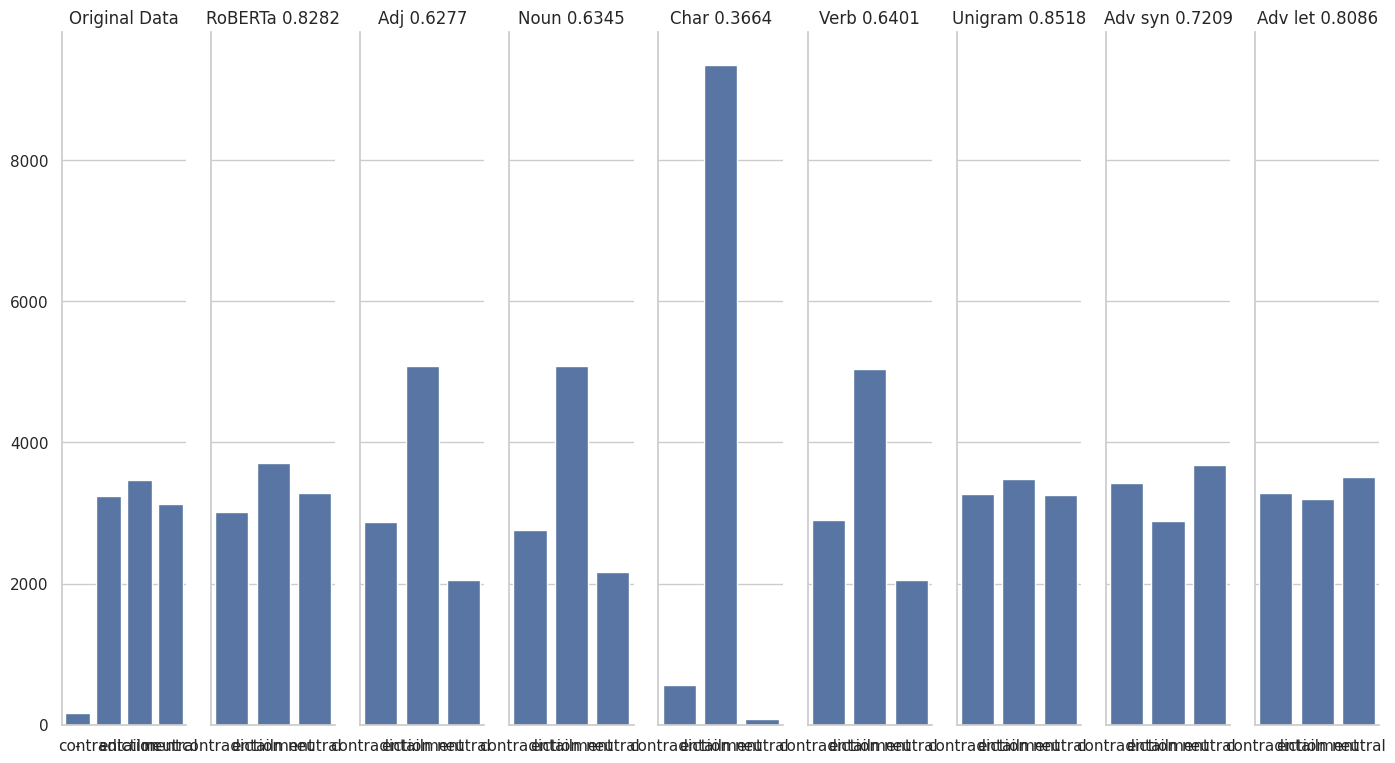

In [20]:
sns.set_theme(style="whitegrid")

def make_bar_plot(result_dict, title, ax):
    sns.barplot(result_dict, ax=ax)
    ax.set_title(title)

fig, axes = plt.subplots(1,9, figsize=(17,9), sharey=True)
make_bar_plot(gt_labels_num, "Original Data", axes[0])
make_bar_plot(results_standard_num, f"RoBERTa {sum(results_standard_labels == gt_labels)/len(gt_labels)}", axes[1])
make_bar_plot(results_adj_num, f"Adj {sum(results_adj_labels == gt_labels)/len(gt_labels)}", axes[2])
make_bar_plot(results_noun_num, f"Noun {sum(results_noun_labels == gt_labels)/len(gt_labels)}", axes[3])
make_bar_plot(results_char_num, f"Char {sum(results_char_labels == gt_labels)/len(gt_labels)}", axes[4])
make_bar_plot(results_verb_num, f"Verb {sum(results_verb_labels == gt_labels)/len(gt_labels)}", axes[5])
make_bar_plot(results_unigram_num, f"Unigram {sum(results_unigram_labels == gt_labels)/len(gt_labels)}", axes[6])
make_bar_plot(results_adv_letter_num, f"Adv syn {sum(results_adv_letter_labels == gt_labels)/len(gt_labels)}", axes[7])
make_bar_plot(results_adv_syn_num, f"Adv let {sum(results_adv_syn_labels == gt_labels)/len(gt_labels)}", axes[8])
sns.despine()
plt.show()